# Pictorial bar chart

![alt text](https://datavizproject.com/wp-content/uploads/2016/06/DVP_101_200-45.png "")

Pictorial bar chart is a visual representation of a bar chart used by designers in infographic. Icons or illustrations  are used instead of bars by either stretching or scaling the length of the object.

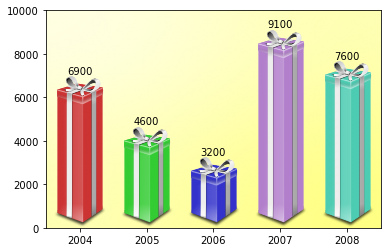

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.image import BboxImage

from matplotlib._png import read_png
import matplotlib.colors
from matplotlib.cbook import get_sample_data


class RibbonBox(object):

    #original_image = read_png(get_sample_data("Minduka_Present_Blue_Pack.png",
    #                                          asfileobj=False))
    original_image = read_png("Minduka_Present_Blue_Pack.png")
    cut_location = 70
    b_and_h = original_image[:, :, 2]
    color = original_image[:, :, 2] - original_image[:, :, 0]
    alpha = original_image[:, :, 3]
    nx = original_image.shape[1]

    def __init__(self, color):
        rgb = matplotlib.colors.to_rgba(color)[:3]

        im = np.empty(self.original_image.shape,
                      self.original_image.dtype)

        im[:, :, :3] = self.b_and_h[:, :, np.newaxis]
        im[:, :, :3] -= self.color[:, :, np.newaxis]*(1. - np.array(rgb))
        im[:, :, 3] = self.alpha

        self.im = im

    def get_stretched_image(self, stretch_factor):
        stretch_factor = max(stretch_factor, 1)
        ny, nx, nch = self.im.shape
        ny2 = int(ny*stretch_factor)

        stretched_image = np.empty((ny2, nx, nch),
                                   self.im.dtype)
        cut = self.im[self.cut_location, :, :]
        stretched_image[:, :, :] = cut
        stretched_image[:self.cut_location, :, :] = \
            self.im[:self.cut_location, :, :]
        stretched_image[-(ny - self.cut_location):, :, :] = \
            self.im[-(ny - self.cut_location):, :, :]

        self._cached_im = stretched_image
        return stretched_image


class RibbonBoxImage(BboxImage):
    zorder = 1

    def __init__(self, bbox, color,
                 cmap=None,
                 norm=None,
                 interpolation=None,
                 origin=None,
                 filternorm=1,
                 filterrad=4.0,
                 resample=False,
                 **kwargs
                 ):

        BboxImage.__init__(self, bbox,
                           cmap=cmap,
                           norm=norm,
                           interpolation=interpolation,
                           origin=origin,
                           filternorm=filternorm,
                           filterrad=filterrad,
                           resample=resample,
                           **kwargs
                           )

        self._ribbonbox = RibbonBox(color)
        self._cached_ny = None

    def draw(self, renderer, *args, **kwargs):

        bbox = self.get_window_extent(renderer)
        stretch_factor = bbox.height / bbox.width

        ny = int(stretch_factor*self._ribbonbox.nx)
        if self._cached_ny != ny:
            arr = self._ribbonbox.get_stretched_image(stretch_factor)
            self.set_array(arr)
            self._cached_ny = ny

        BboxImage.draw(self, renderer, *args, **kwargs)


if 1:
    from matplotlib.transforms import Bbox, TransformedBbox
    from matplotlib.ticker import ScalarFormatter

    fig, ax = plt.subplots()

    years = np.arange(2004, 2009)
    box_colors = [(0.8, 0.2, 0.2),
                  (0.2, 0.8, 0.2),
                  (0.2, 0.2, 0.8),
                  (0.7, 0.5, 0.8),
                  (0.3, 0.8, 0.7),
                  ]
    heights = np.random.random(years.shape) * 7000 + 3000

    fmt = ScalarFormatter(useOffset=False)
    ax.xaxis.set_major_formatter(fmt)

    for year, h, bc in zip(years, heights, box_colors):
        bbox0 = Bbox.from_extents(year - 0.4, 0., year + 0.4, h)
        bbox = TransformedBbox(bbox0, ax.transData)
        rb_patch = RibbonBoxImage(bbox, bc, interpolation="bicubic")

        ax.add_artist(rb_patch)

        ax.annotate(r"%d" % (int(h/100.)*100),
                    (year, h), va="bottom", ha="center")

    patch_gradient = BboxImage(ax.bbox,
                               interpolation="bicubic",
                               zorder=0.1,
                               )
    gradient = np.zeros((2, 2, 4), dtype=np.float)
    gradient[:, :, :3] = [1, 1, 0.]
    gradient[:, :, 3] = [[0.1, 0.3], [0.3, 0.5]]  # alpha channel
    patch_gradient.set_array(gradient)
    ax.add_artist(patch_gradient)

    ax.set_xlim(years[0] - 0.5, years[-1] + 0.5)
    ax.set_ylim(0, 10000)

    fig.savefig('ribbon_box.png')
    plt.show()